# Analyzing Correlating Factors in Amazon Product Reviews

In [1]:
import pandas
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from numpy import polyfit
import scipy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import os
from math import *
import math
import os.path
import sklearn.feature_extraction.text
from sklearn.cross_validation import cross_val_score
from  sklearn.feature_extraction.text import CountVectorizer
from  sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import nltk

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
df1 = pandas.read_json('Beauty_5.json', lines=True)
df2 = pandas.read_json('Clothing_Shoes_and_Jewelry_5.json', lines=True)
df3 = pandas.read_json('Video_Games_5.json', lines=True)
df = pandas.concat([df1[0:100000],df2[0:100000],               
                    df3[0:100000]])

print len(df)

300000


In [ ]:
#After pre-processing our json we can begin analysis of our factors. 
#We'll study Helpfullness Rating, ReviewTime, Lexical Diversity, Sentiment and Keywords/Cost
#as they correlate to the Reviewer's Product Review Score

# Review Score Vs. Helpfulness Rating

In [ ]:
#Since the helpfulness rating is a criteria that OTHER consumers guage a review on, the rating can be thought
#of as a measure of influence one review has on other consumers' spending choices and product opinions.
#Do the the most helpful reviews primarily correlate with positive reviews
#or is there an entirely different correlation?

## Data Processing Step for Review Score Vs. Helpulness Rating

In [12]:
desk = pandas.DataFrame()

#Now let's also normalize our data to exclude reviews 
#with 0/0 helpfulness rating  (indicating no helpfulness score has been given)

helpfulScoresNormalized = []
overallsNormalized = []

for a,b in zip( df.helpful, df.overall):
    if int(a[1]) != 0:
         overallsNormalized.append(int(b))
         helpfulScoresNormalized.append( float(a[0])/float(a[1]))
             
desk['helpfulScoresNormalized'] = np.array(helpfulScoresNormalized)
desk['overallsNormalized'] =  np.array(overallsNormalized)
desk = desk.sort_values(['helpfulScoresNormalized'], ascending=True)

num = 0.0
total  = 0
cumTot = []
for a in desk['overallsNormalized']:
    total += a
    num += 1.0
    cumTot.append(total/num)
    
desk['cumTot'] = np.array(cumTot)

## Dimensionality Reduct-Visualization for Review Score Vs. Helpfulness Rating

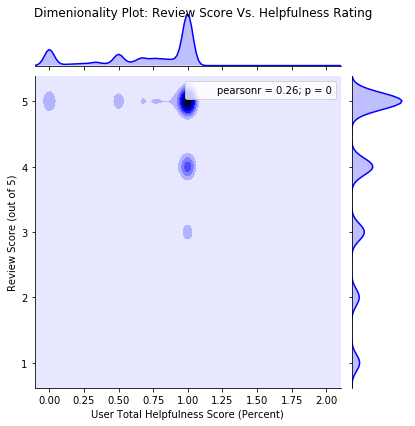

In [18]:
g = sns.jointplot(x=desk['helpfulScoresNormalized'], y=desk['overallsNormalized'], kind="kde", color="Blue")
g.fig.suptitle('Dimenionality Plot: Review Score Vs. Helpfulness Rating')
g.set_axis_labels("Review Total Helpfulness Rating (Percent)", "Review Score (out of 5)")
plt.show()
g.savefig("DSVH.png")

## Linear and Poly Regression for Review Score vs Helpfulness Rating 

In [81]:
hScores = []
for num in range(1,11):
   hScores.append((polyfit(desk['helpfulScoresNormalized'], desk['cumTot'] ,num,full=True,cov= True)))

for a in hScores:
    #print a[1] #gives residuals (sum squared residuals)
    #print a[0] gives all coefficients
    #print a[1][0]/3000     #average error
    #print np.trace( np.asarray(a[1])) #When full=Fals and cov = True, a[1]'s diags give covariance
    #print sqrt(np.trace( np.asarray(a[1]))) #When full=Fals and cov = True, sqrt a[1]'s diags give std

#print a[1], then  judge residuals, then choose a polynomial size to graph!

0.873647519002
0.162183104998
0.161069445544
0.160487898401
0.152759258305
0.137614912542
0.136119121148
0.135060792431
0.133360376087
0.131926451926


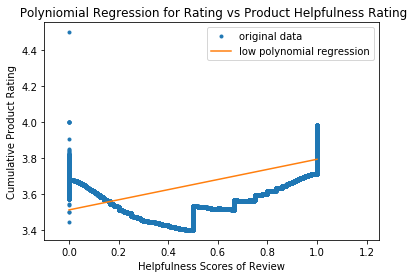

In [74]:
xpts = np.linspace(0, 1, 50)
plt.plot(desk['helpfulScoresNormalized'], desk['cumTot'] ,'.',label='original data')
plt.ylabel('Cumulative Product Rating')
plt.xlabel('Helpfulness Scores of Review')
plt.title(" Polyniomial Regression for Rating vs Product Helpfulness Rating")
plt.plot(xpts, np.poly1d((hScores[0][0]))(xpts), '-', label='low polynomial regression')
#plt.plot(xpts, highPoly(xpts), '--',label='high polynomial regression')
plt.xlim(-.1,1.25)
plt.legend()
plt.show()

# Review Score Vs.Time (Of Posted Review)

In [ ]:
#While one may not expect to find any significant correlation between time of posted reviews and review score, there may
#be some unexpected correlations between these factors. In technology related products, performance, battery life, durability
#and price expectations -and thus reviews for products may change rapidly due to the innovative nature of the tech industry.

## Data Processing Step for Review Score Vs. Time

In [105]:
desk = pandas.DataFrame()            
desk['unixReviewTime'] = df.unixReviewTime
desk['overall'] =  df.overall
desk = desk.sort_values(['unixReviewTime'], ascending=True)

num = 0.0
total  = 0
cumTot = []
for a in desk['overall']:
    total += a
    num += 1.0
    cumTot.append(total/num)
    
desk['cumTot'] = np.array(cumTot)

## Dimensionality Reduct-Visualization for Review Score Vs. Time

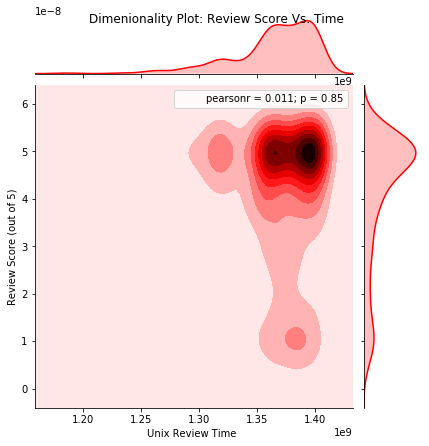

In [14]:
g = sns.jointplot(x=desk.unixReviewTime[0:stop].as_matrix(), y=desk.overall[0:stop].as_matrix(), kind="kde", color="Red")
g.fig.suptitle('Dimenionality Plot: Review Score Vs. Time')
g.set_axis_labels("Unix Review Time ", "Review Score (out of 5)")
plt.show()

# Linear and Poly Regression for Review Score Vs Time

In [96]:
hScores = []
for num in range(1,8):
   hScores.append((polyfit(desk['unixReviewTime'], desk['cumTot'] ,num,full=True,cov= True)))

for a in hScores:
    #print a[1][0] #gives residuals (sum squared residuals)
    #print a[0] #gives all coefficients
    #print a[1][0]/3000     #average error
    #print np.trace( np.asarray(a[1])) #When full=False , a[1]'s diags give covariance
    #print sqrt(np.trace( np.asarray(a[1]))) #When full=False., sqrt a[1]'s diags give std

#print a[1], then  judge residuals, then choose a polynomial size to graph!

0.000840302762887
0.00401096934392
0.0228744698364
0.206954640136
2.00934382117
7.94315625791
9.24322229302


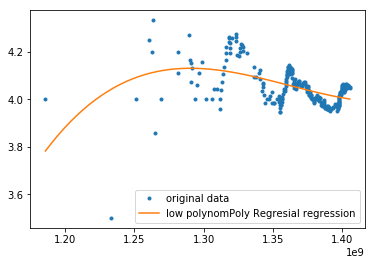

In [17]:
lowPoly  = np.poly1d(polyfit(desk.unixReviewTime, desk['cumTot'],3 ))
#highPoly = np.poly1d(polyfit(desk.unixReviewTime, desk.overall,np.random.randint(10, high=15, dtype="I") ))

xpts = np.linspace(min(desk['unixReviewTime'].as_matrix()), max(desk['unixReviewTime'].as_matrix()), 50)
plt.plot(desk.unixReviewTime, desk.cumTot,'.',label='original data')
plt.plot(xpts, lowPoly(xpts), '-', label='low polynomPoly Regresial regression')
#plt.plot(xpts, highPoly(xpts), '--',label='high polynomial regression')
plt.legend()

plt.show()

# Review Score Vs. Keywords Frequency Analysis

In [ ]:
#A popular analysis for social media and marketing, our keyword analysis will allow us to discover the top terms in the set our
#Amazon reviews. We may expect indicitive words such as cost, cheap, good, bad, etc to be most frequently used in most of
#our reviews. After finding the most frequent words,we will then analyze
#correlations between review scores and reviews that freuently use our trend-words/keywords. 

#In a real world application, one might want to analyze review score Vs. Trend for one one word at a time 
#(or use their own set of simularly related keywords) to get a more zoomed in look at how a 
#topic or trend influences review score

## Processing Keywords and Frequency

In [111]:
#desk = pandas.DataFrame()
#top = ['cost','low','high','cheap','expensive','worth','value','money','deal']

#counts = []
#for a,c in zip(df.reviewText , df.overall) :
#    ct = 0 
#    sent = a.split()
#    for b in sent:
#        if b in top:
#            ct += 1
#    counts.append(ct)     
#print len(counts)   
#desk['counts']   = np.array(counts)
#desk['overall'] =  df.overall

desk = desk.sort_values(['counts'], ascending=True)

num = 0.0
total  = 0
cumTot = []
for a in desk['overall']:
    total += a
    num += 1.0
    cumTot.append(total/num)
desk['cumTot'] = np.array(cumTot)

## Dimensionality Reduct-Visualization for Review Score Vs. Keyword Frequency

In [ ]:
#Normalized to show how people who did use the words rate the product

g = sns.jointplot(x=desk['counts'] , y=desk['overalls'], kind="kde", color="Blue")
g.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Number of Keywords Used in Review ", "Review Score (out of 5)")
sns.rugplot(desk['counts'] , color="r", ax=g.ax_joint)
sns.rugplot(desk['overalls'], vertical=True, ax=g.ax_joint)

plt.show()


## Linear and Poly Regression for Review Score  vs Keword Frequency

In [97]:
hScores = []
for num in range(1,8):
   hScores.append((polyfit(desk['counts'], desk['cumTot'] ,num,full=True,cov= True)))

for a in hScores:
    print a[1][0] #gives residuals (sum squared residuals)
    #print a[0] #gives all coefficients
    #print a[1][0]/3000     #average error
    #print np.trace( np.asarray(a[1])) #When full=False , a[1]'s diags give covariance
    #print sqrt(np.trace( np.asarray(a[1]))) #When full=False., sqrt a[1]'s diags give std

#print a[1], then  judge residuals, then choose a polynomial size to graph!

461.699673487
90.9553046553
27.3483884991
22.8939927191
20.876774813
20.1660998086
11.0631593826


In [ ]:
lowPoly  = np.poly1d(polyfit(desk['counts'],desk['cumTot'] ,np.random.randint(2, high=10, dtype="I") ))
highPoly = np.poly1d(polyfit(desk['counts'],desk['cumTot'] ,np.random.randint(10, high=15, dtype="I") ))


xpts = np.linspace(0, 40, 100)
plt.plot(desk['counts'], desk['cumTot'] ,'.',label='original data')
plt.plot(xpts, lowPoly(xpts), '-', label='low polynomial regression')
plt.plot(xpts, highPoly(xpts), '--',label='high polynomial regression')
plt.legend()
plt.ylim(0,6)
plt.show()

# Review Score Vs Lexical Diversity

In [ ]:
#Are more articulate reviews associated with better or worse ratings? If a product has specific criticisms, maybe more reviewers
#are willing to articulate on those issues and good product reviews are shorter. Maybe vice versa?

## Processing Lexical Diversity

In [127]:
'''
desk = pandas.DataFrame()
def lexical_diversity(text):
    return len(set(text)) / ((len(text))*1.0)

divRates = []
 
for a in df.reviewText:
    if len(a) <= 0 :
        divRates.append(0)
    else:
        divRates.append(lexical_diversity(a))
'''

#desk['overall'] =  df.overall
desk = pandas.DataFrame()            
#desk['unixReviewTime'] = df.unixReviewTime
desk['overall'] =  df.overall
desk['divRates'] = np.array(divRates)

desk = desk.sort_values(['divRates'], ascending=True)

num = 0.0
total  = 0
cumTot = []
for a in desk['overall']:
    total += a
    num += 1.0
    cumTot.append(total/num)
    
desk['cumTot'] = np.array(cumTot)

## Dimensionality Reduct-Visualization for Review Score Vs. Lexical Diveristy

In [ ]:
g = sns.jointplot(x=desk['divRates'], y=desk['overall'] , kind="kde", color="Green")
g.plot_joint(plt.scatter, c="y", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Lexical Diversity Score","Review Score (out of 5)")
sns.rugplot(desk['divRates'], color="red", ax=g.ax_joint)
sns.rugplot(desk['overalls'] , vertical=True, ax=g.ax_joint)

plt.show()

## Linear and Poly Regression for Review Score Vs. Lexical Diversity

In [134]:
hScores = []
for num in range(1,11):
   hScores.append((polyfit(desk['divRates'], desk['cumTot'] ,num,full=False,cov= True)))

for a in hScores:
    #print a[1][0] #gives residuals (sum squared residuals)
    #print a[0] #gives all coefficients
    #print a[1][0]/3000     #average error
    #print np.trace( np.asarray(a[1])) #When full=False , a[1]'s diags give covariance
    print sqrt(np.trace( np.asarray(a[1]))) #When full=False., sqrt a[1]'s diags give std

#print a[1], then  judge residuals, then choose a polynomial size to graph!

0.000423769907671
0.000986110583869
0.00566710045521
0.0223374436631
0.111167098494
0.62663737481
3.50616297771
21.0146595422
125.441181589
754.265578916


In [ ]:
lowPoly  = np.poly1d(polyfit(desk['divRates'], desk['cumTot'],np.random.randint(2, high=10, dtype="I") ))
highPoly = np.poly1d(polyfit(desk['divRates'], desk['cumTot'],np.random.randint(10, high=13, dtype="I") ))


xpts = np.linspace(min(desk['divRates'].as_matrix()), max(desk['divRates'].as_matrix()), 50)
plt.plot(desk['divRates'], desk['cumTot'],'.',label='original data')
plt.plot(xpts, lowPoly(xpts), '-', label='low polynomial regression')
plt.plot(xpts, highPoly(xpts), '--',label='high polynomial regression')
plt.legend()
plt.ylim(0,6)
plt.show()

# Review Score Vs Sentiment Analysis

In [ ]:
#Are higher rated reviewers more critical of products? Perhaps this is a stronger trend with 4 Star reviews?

In [137]:
print len (sentiment)

24248


## Data Processsing For Sentiment Analysis

In [136]:
desk = pandas.DataFrame()
sentiment = []

for a in df.reviewText:
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(a)
    sentiment.append(ss['compound'])

desk['sentiment'] = np.array(sentiment) 
desk['overall'] =  df.overall


desk = desk.sort_values(['sentiment'], ascending=True)

num = 0.0
total  = 0
cumTot = []
for a in desk['overall']:
    total += a
    num += 1.0
    cumTot.append(total/num)
desk['cumTot'] = cumTot

KeyboardInterrupt: 

## Dimensionality Reduct-Visualization for Review Scores Vs. Sentiment Analysis

In [ ]:
g = sns.jointplot(x=desk['sentiment'], y=desk['overalls'] , kind="kde", color="Green")
g.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Composite Sentiment Analysis Score ","Review Score (out of 5)")
sns.rugplot(desk['sentiment'], color="g", ax=g.ax_joint)
sns.rugplot(desk['overalls'], vertical=True, ax=g.ax_joint)

plt.show()

## Linear and Poly Regression for Review Score Vs. Sentiment Analysis

In [ ]:
for a in hScores:
    #print a[1][0] #gives residuals (sum squared residuals)
    #print a[0] #gives all coefficients
    #print a[1][0]/3000     #average error
    #print np.trace( np.asarray(a[1])) #When full=False , a[1]'s diags give covariance
    print sqrt(np.trace( np.asarray(a[1]))) #When full=False., sqrt a[1]'s diags give std

#print a[1], then  judge residuals, then choose a polynomial size to graph!

In [ ]:
lowPoly  = np.poly1d(polyfit(desk['sentiment'], desk['cumTot'],np.random.randint(2, high=10, dtype="I") ))
highPoly = np.poly1d(polyfit(desk['sentiment'], desk['cumTot'],np.random.randint(10, high=13, dtype="I") ))

hScores = []
for num in range(1,11):
   hScores.append((polyfit(desk['divRates'], desk['cumTot'] ,num,full=False,cov= True)))


xpts = np.linspace(min(desk['sentiment'].as_matrix()), max(desk['sentiment'].as_matrix()), 50)
plt.plot(desk['sentiment'], desk['cumTot'],'.',label='original data')
plt.plot(xpts, lowPoly(xpts), '-', label='low polynomial regression')
plt.plot(xpts, highPoly(xpts), '--',label='high polynomial regression')
plt.legend()
#plt.ylim(0,6)
plt.show()